In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LinearRegression

In [2]:
weather_data = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../data/Plant_1_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
X= merged_df.loc[:, ['DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

array([[0.        , 0.32219047, 0.09950559, 0.        ],
       [0.        , 0.32219047, 0.09950559, 0.        ],
       [0.        , 0.32219047, 0.09950559, 0.        ],
       ...,
       [0.        , 0.10170895, 0.0482553 , 0.        ],
       [0.        , 0.10170895, 0.0482553 , 0.        ],
       [0.        , 0.10170895, 0.0482553 , 0.        ]])

## AK 
## 1. The one modification that stopped the issue of no fit at all was the change of the optimizer to adam. I suppose the other one often would cause to diverging and not let the data get properly fit. After this change the variation is still around, but it seems not its not a no fit->some fit variation, but just difference between fits.
## 2. Other things I have tried is playing around with the activation layers. Seems like keeping it to relu and sigmoid allows to make the fit better. So the data gets properly fit sooner. See the simple and medium autoencoders for example.
## 3. Finally to remove the actual variation that now is only due to stochasticity I simplified the autoencoder architectures. In the simplest case we have one single layer with hidden units. 2 hidden units wasn't enough. It wouldn't allow the DC power signal be fitted properly. 3 hidden units seems to be flexible enough to fit everything well. This simple case is stable. The values do not change drammatically from one run to another. I have compared the final daily inverter inefficiency tables. + the two problematic inverters do actually consistently result to have the highest error.
## In the second test I created an autoencoder model that actually has a slightly more complex structure. Like in yor original design, it first increases the number of units then decreases them, allowing the network to create additional variables, like I was explainging in one of our meetings. This setup also seems to be stable enough, and gives similar results to the simpler case.
## I have to look in more detail at the functions for deriving the outliers etc to do a more systematic comparison of the outputs. But they generally seem in line. At least as much as it regards the autoencoder stability

In [3]:
input_layer = Input(shape =(X.shape[1], ))

encoded = Dense(100, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(75, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(50, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation ='relu')(encoded)

decoded = Dense(12, activation ='tanh')(encoded)
decoded = Dense(25, activation ='tanh')(decoded)
decoded = Dense(50, activation ='tanh')(decoded)
decoded = Dense(75, activation ='tanh')(decoded)
decoded = Dense(100, activation ='tanh')(decoded)

output_layer = Dense(X.shape[1], activation ='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adam", loss ="mse")

History=autoencoder.fit(X_scaled, X_scaled,batch_size = 100, epochs = 20,shuffle = True, validation_split = 0.10)

Epoch 1/20
619/619 [==============================] - 8s 10ms/step - loss: 0.0120 - val_loss: 5.0257e-04
Epoch 2/20
619/619 [==============================] - 4s 6ms/step - loss: 6.1569e-04 - val_loss: 3.7478e-04
Epoch 3/20
619/619 [==============================] - 5s 8ms/step - loss: 4.4434e-04 - val_loss: 2.2714e-04
Epoch 4/20
619/619 [==============================] - 5s 8ms/step - loss: 3.4574e-04 - val_loss: 2.1021e-04
Epoch 5/20
619/619 [==============================] - 3s 5ms/step - loss: 2.9807e-04 - val_loss: 1.8336e-04
Epoch 6/20
619/619 [==============================] - 2s 4ms/step - loss: 2.4013e-04 - val_loss: 1.7130e-04
Epoch 7/20
619/619 [==============================] - 3s 4ms/step - loss: 2.2649e-04 - val_loss: 1.1858e-04
Epoch 8/20
619/619 [==============================] - 2s 4ms/step - loss: 2.1664e-04 - val_loss: 1.1027e-04
Epoch 9/20
619/619 [==============================] - 2s 4ms/step - loss: 1.7807e-04 - val_loss: 1.0282e-04
Epoch 10/20
619/619 [==========

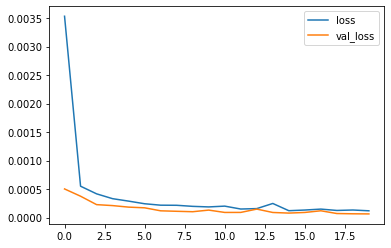

In [4]:
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [5]:
encoded_train_data=autoencoder.predict(X_scaled)
scaled_train_features = pd.DataFrame(encoded_train_data, index=X.index, columns=X.columns)
X_scaled_df=pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
train_mae_loss = np.mean((X_scaled_df - scaled_train_features)**2, axis=1)
train_mae_loss

0        0.000003
1        0.000003
2        0.000003
3        0.000003
4        0.000003
           ...   
68769    0.000002
68770    0.000002
68771    0.000002
68772    0.000002
68773    0.000002
Length: 68774, dtype: float64

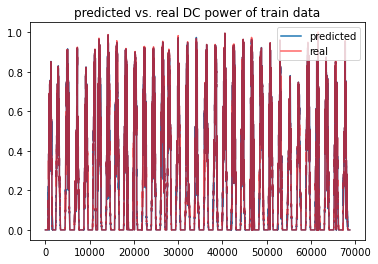

In [6]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_train_features.DC_POWER, label='predicted')
plt.plot(X_scaled_df.DC_POWER, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real DC power of train data')
plt.legend()
plt.show()

In [7]:
merged_err=merged_df.join(pd.DataFrame(train_mae_loss))
merged_err.rename(columns={0: 'ERROR'}, inplace=True)
merged_err.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR,ERROR
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000003
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000003
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000003
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000003
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0,0.000003


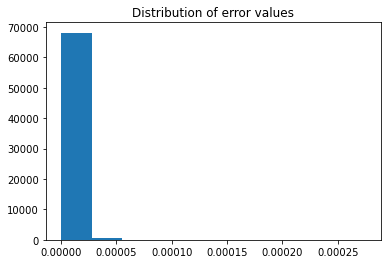

In [8]:
plt.hist(merged_err['ERROR'])
plt.title('Distribution of error values')
plt.show()

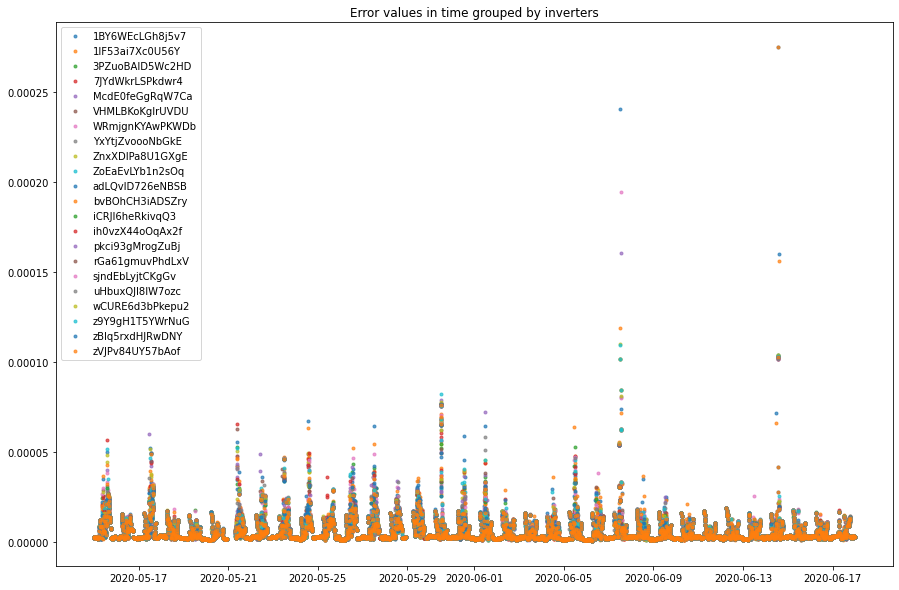

In [9]:
plt.figure(figsize=(15, 10))
for i, inv in merged_err.groupby(merged_err.SOURCE_KEY):
    plt.plot_date(inv.DATE_TIME, inv.ERROR,'.', label=i, alpha=0.7)
#     plt.show()
plt.legend()
plt.title('Error values in time grouped by inverters')
plt.show()

In [10]:
def get_outliers_in_time(data, column, groupby_column, output_column_name=False, outlier_limit=3):
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    for i, group in  data.groupby(data[groupby_column]):
        outlier_condition1=group[column]>(group[column].mean() + outlier_limit*group[column].std())
        outlier_condition2=group[column]<(group[column].mean() - outlier_limit*group[column].std())
        data.loc[group[outlier_condition1|outlier_condition2].index, output_column_name]=1
    return data
def get_outlier_errors(data, column, output_column_name=False, outlier_limit=3, window='7d'):
    cleaned_column='cleaned'
    if output_column_name==False:
        output_column_name=column+"_outliers"
    resorted=data.set_index('DATE_TIME').copy()
    resorted[cleaned_column]=np.where(resorted[column]>0, resorted[column], np.nan)
    resorted[output_column_name]=0
    num=resorted.SOURCE_KEY.nunique()
    outlier_condition1= resorted[cleaned_column]>resorted[cleaned_column].rolling(window=window, min_periods=num*8*4).mean()+outlier_limit*resorted[cleaned_column].rolling(window=window, min_periods=num*8*4).std()
    resorted.loc[outlier_condition1, output_column_name]=1
    return resorted.drop(columns=[cleaned_column]).reset_index()

## AK basically when working with the error in order to find the single outlying points you should be looking for the points with the highest errors, so you don't need to do more complex things like using the function above. 
## What you want is using the average error values for the past week (or other time window) to derive the extremely high error values for the moment. This is what I have done in the function above. 
## This is what you are looking for, so using a groupby is already more complex than what we need. We can talk about it in the meeting maybe
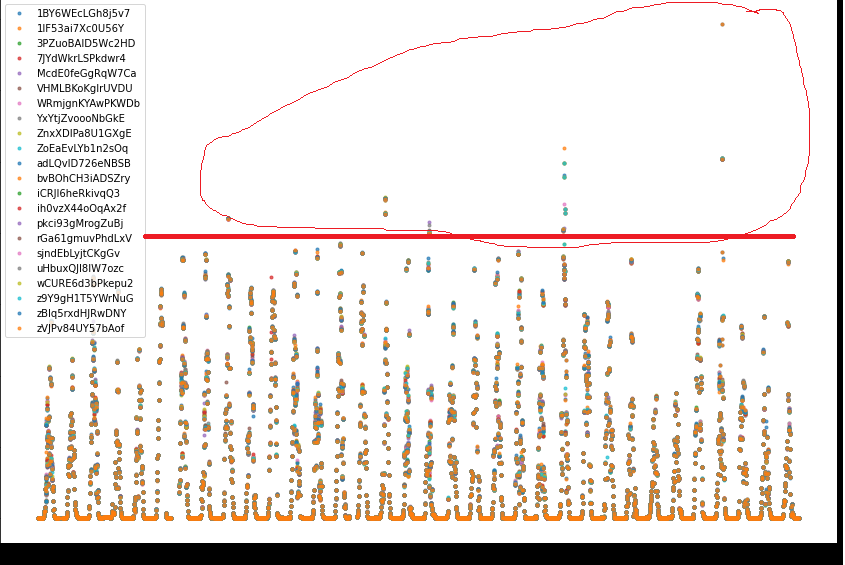

In [11]:
merged_outliers=get_outlier_errors(merged_err, 'ERROR', output_column_name="alarm_error_outlier", outlier_limit=10)

In [12]:
merged_dc_outlier=get_outliers_in_time(merged_outliers, 'DC_POWER', 'HOUR', output_column_name="alarm_DC_conversion_outlier", outlier_limit=3)

## AK I don't expect that DC to AC conversion anomalies can be found with the autoencoder in this setting. We designed it to not include AC information. If you are curious you can add the AC POWER column as well to the autoencoder and see whether the new anomalous points coincide with the outliers_by_Residual below. But when using just DC power in the autoencoder I'd keep the DC to AC conversion info out of the plot, just for simplicity.

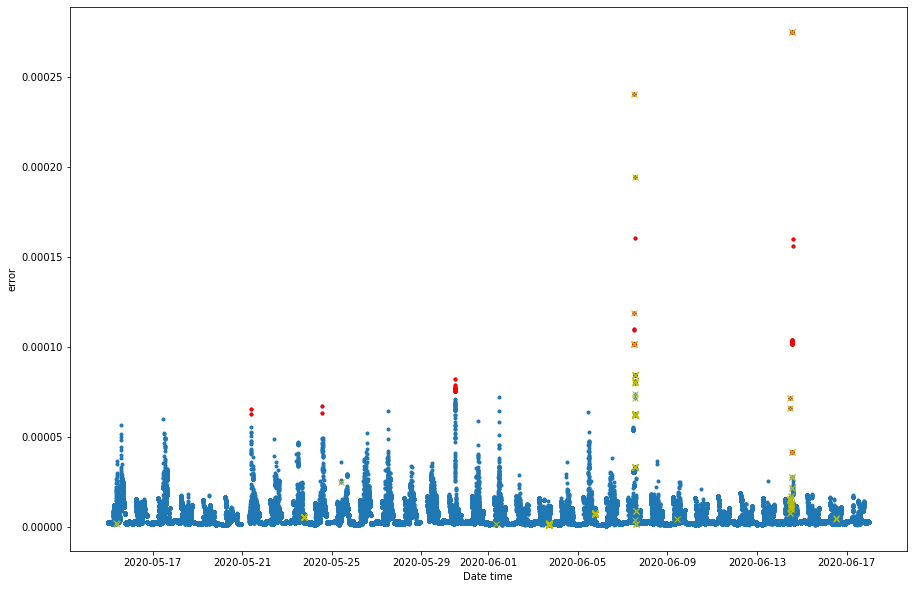

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(merged_dc_outlier['DATE_TIME'], merged_dc_outlier['ERROR'], '.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_error_outlier"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_error_outlier"]==1]['ERROR'], 'r.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['ERROR'], 'yx')
#plt.plot(merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['DATE_TIME'], 
#         merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['ERROR'], 'gx')
plt.xlabel('Date time')
plt.ylabel('error')
plt.show()

###### We can see that the high error rates are mainly caused by the errors that happen during Irradiation to DC and DC to AC conversions.

## 2. Inverter level efficiency
#### a) Take the mean of the reconstruction error for each inverter after removing the outliers

In [14]:
print(merged_outliers[merged_outliers.alarm_error_outlier == 1].shape)
clean_data=merged_outliers.copy()
print(clean_data.shape)
#clean_data.drop(clean_data.loc[clean_data.alarm_error_outlier == 1].index, inplace=True)
print(clean_data.shape)  

(72, 19)
(68774, 19)
(68774, 19)


In [15]:
def inverter_error(data):
    mean_error=[]
    inverters=[]
    for i, inv in data.groupby(data.SOURCE_KEY):
        ind = inv[inv['SOURCE_KEY']==i].index.values
        m = inv.ERROR.mean()
        mean_error.append(m)
        inverters.append(i)
    inv_error_df = pd.DataFrame(data=np.array(mean_error), columns=['MEAN_ERROR'])
    source_key = pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
    inv_error_df['SOURCE_KEY'] = source_key['SOURCE_KEY']
    return(inv_error_df)

In [16]:
inv_error_df=inverter_error(clean_data)
inv_error_df.head()

,MEAN_ERROR,SOURCE_KEY
0,0.000006,1BY6WEcLGh8j5v7
1,0.000005,1IF53ai7Xc0U56Y
2,0.000005,3PZuoBAID5Wc2HD
3,0.000005,7JYdWkrLSPkdwr4
4,0.000005,McdE0feGgRqW7Ca


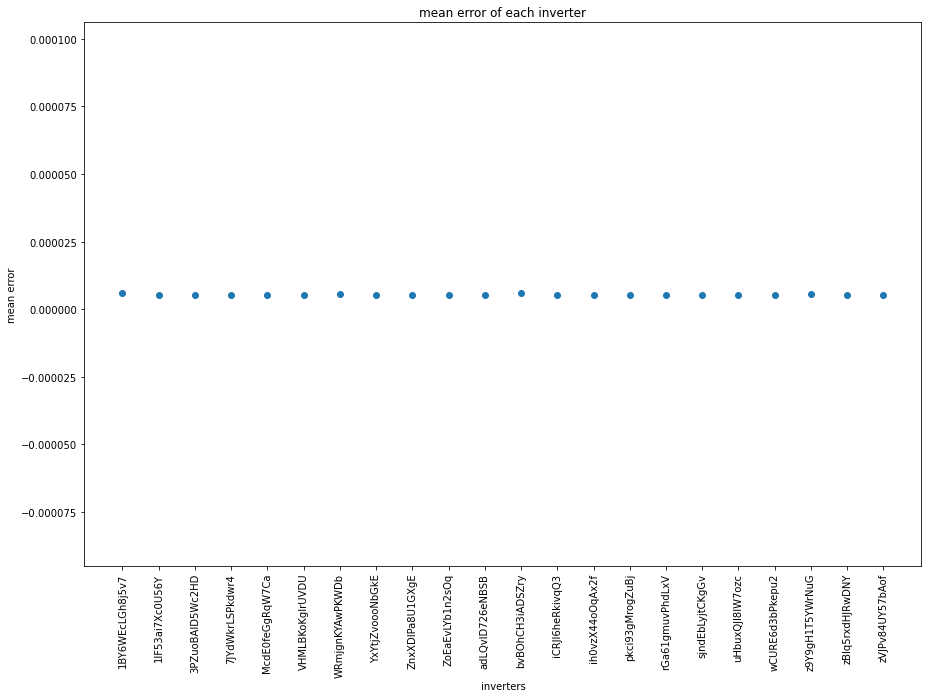

In [17]:
plt.figure(figsize=(15, 10))
plt.scatter(inv_error_df.SOURCE_KEY,inv_error_df.MEAN_ERROR)
plt.xticks(rotation=90) 
plt.ylim(inv_error_df.MEAN_ERROR.min()-0.0001,inv_error_df.MEAN_ERROR.max()+0.0001)
plt.xlabel('inverters')
plt.ylabel('mean error')
plt.title('mean error of each inverter')
plt.show()

#### b) Calculate a mean reconstruction error per inverter per day and then compare those mean values to find inverters with higher mean reconstruction error in a single day and then over several days.

In [18]:
def daily_inverter_error(data):
    mean_error=[]
    inverters=[]
    days=[]
    for a, day in data.groupby(data.DAY):
        for i, inv in day.groupby(day.SOURCE_KEY):
            ind = inv[inv['SOURCE_KEY']==i].index.values
            m = inv.ERROR.mean()
            mean_error.append(m)
            inverters.append(i)
            days.append(a)
    inv_error_df = pd.DataFrame(data=np.array(mean_error), columns=['MEAN_ERROR'])
    source_key = pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
    Days = pd.DataFrame(data=np.array(days), columns=['DAY'])
    inv_error_df['SOURCE_KEY'] = source_key['SOURCE_KEY']
    inv_error_df['DAY']=Days['DAY']
    return(inv_error_df)

In [19]:
daily_inv_error_df=daily_inverter_error(clean_data)
daily_inv_error_df

,MEAN_ERROR,SOURCE_KEY,DAY
0,0.000008,1BY6WEcLGh8j5v7,136
1,0.000008,1IF53ai7Xc0U56Y,136
2,0.000008,3PZuoBAID5Wc2HD,136
3,0.000008,7JYdWkrLSPkdwr4,136
4,0.000007,McdE0feGgRqW7Ca,136
...,...,...,...
743,0.000005,uHbuxQJl8lW7ozc,169
744,0.000005,wCURE6d3bPkepu2,169
745,0.000005,z9Y9gH1T5YWrNuG,169
746,0.000005,zBIq5rxdHJRwDNY,169


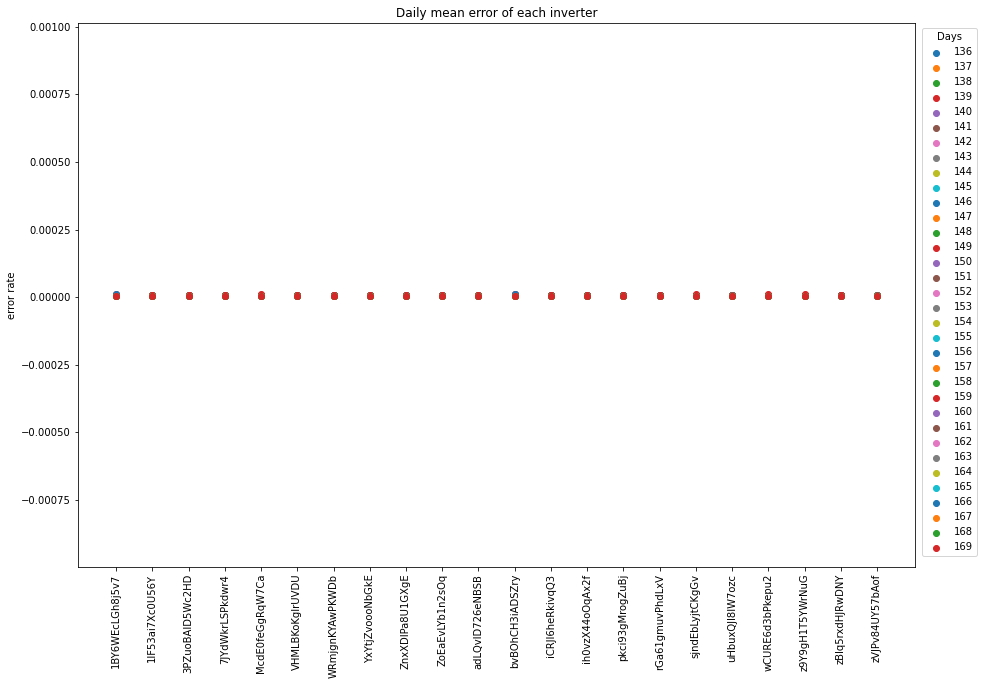

In [20]:
plt.figure(figsize=(15, 10))
for i, day in daily_inv_error_df.groupby(daily_inv_error_df.DAY):
    plt.scatter(day.SOURCE_KEY, day.MEAN_ERROR, label=i)
plt.xticks(rotation=90)
plt.ylim(daily_inv_error_df.MEAN_ERROR.min()-0.001,daily_inv_error_df.MEAN_ERROR.max()+0.001)
plt.ylabel('error rate')
plt.legend(loc="upper right", title="Days", bbox_to_anchor=(1.08, 1))
plt.title('Daily mean error of each inverter')
plt.show()

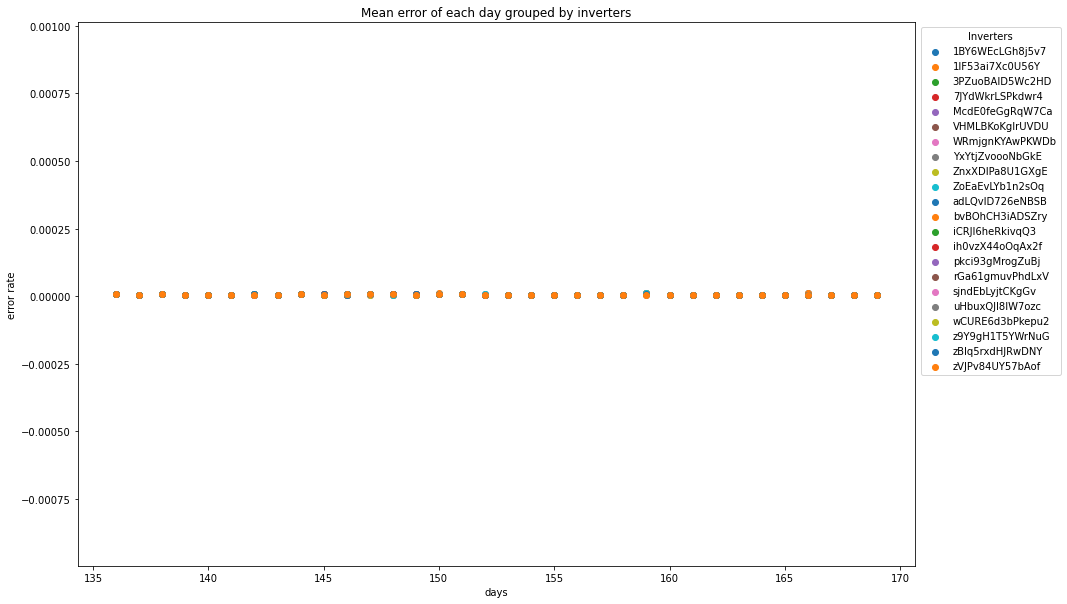

In [21]:
plt.figure(figsize=(15, 10))
for i, inv in daily_inv_error_df.groupby(daily_inv_error_df.SOURCE_KEY):
    plt.scatter(inv.DAY, inv.MEAN_ERROR, label=i)
plt.ylim(daily_inv_error_df.MEAN_ERROR.min()-0.001,daily_inv_error_df.MEAN_ERROR.max()+0.001)
plt.ylabel('error rate')
plt.xlabel('days')
plt.legend(loc="upper right", title="Inverters", bbox_to_anchor=(1.18, 1))
plt.title('Mean error of each day grouped by inverters')
plt.show()

## AK adding the calculation of the inefficient inverters. The plot above is not really showing whether there are inverter errors shifted from the group in a single day, beacuse the day by day variation is large and the single day inverter errors appear all too close to each other. You have to zoom in to be able to see that in this dense group in reality some are actually different from the others. The calculation below derives them so we can also see mathematically that they exist. 
## In itself that the day to day error variation is so high, I suppose is another sign that something is not working well with the autoencoder

In [22]:
def get_inefficient_inverters_day(data, column, output_column_name, anomaly_limit = 2):
    data[output_column_name] = 0
    for _,d in data.groupby('DAY'):
        col_mean = d[column].mean()
        col_std = d[column].std()
        data.loc[d[(d[column] > col_mean + anomaly_limit * col_std)].index,output_column_name] = 1
    return data
def get_inefficient_inverters_window(data, column, output_column_name, window=7):
    data[output_column_name] = 0
    for inv in data['SOURCE_KEY'].unique():
        data.loc[data['SOURCE_KEY']==inv, output_column_name]=data[data['SOURCE_KEY']==inv][column].rolling(window = window).min()
    return data

Text(0, 0.5, 'DC conversion coefficient')

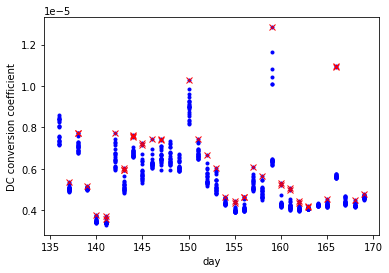

In [23]:
daily_inv_error_df = get_inefficient_inverters_day(daily_inv_error_df, 'MEAN_ERROR', 'alarm_inefficient_inverter_day')
data=daily_inv_error_df
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['MEAN_ERROR'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_day==1]['DAY'], data[data.alarm_inefficient_inverter_day==1]['MEAN_ERROR'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

In [24]:
daily_inv_error_df[daily_inv_error_df['alarm_inefficient_inverter_day']==1]

,MEAN_ERROR,SOURCE_KEY,DAY,alarm_inefficient_inverter_day
36,0.000005,pkci93gMrogZuBj,137,1
44,0.000008,1BY6WEcLGh8j5v7,138,1
55,0.000008,bvBOhCH3iADSZry,138,1
77,0.000005,bvBOhCH3iADSZry,139,1
94,0.000004,WRmjgnKYAwPKWDb,140,1
110,0.000004,1BY6WEcLGh8j5v7,141,1
121,0.000004,bvBOhCH3iADSZry,141,1
143,0.000008,bvBOhCH3iADSZry,142,1
154,0.000006,1BY6WEcLGh8j5v7,143,1
158,0.000006,McdE0feGgRqW7Ca,143,1
